# Optimal Private Minimim Spanning Trees using Input Perturbation

In [2]:
import math
import random
from statistics import median

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.ma.core import repeat

from src.mst.pamst import pamst, comp_mst_weight
from src.mst.mst_utilities import compute_real_mst_weight, generate_random_complete_graph, compute_input_perturbation, generate_hard_instance

sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})

In [9]:
# Computing Private Minimum Spanning Trees using Different Algorithms, Using l_infty neighboroing relationsip

# Privacy Parameters
#rho_values = [0.1,0.015,0.2,0.375,0.5,1,2,4,6,10, 100, 200]
rho_values = np.arange(0.1, 2500, 20)
n = 100
sensitivity = 1

# Generate a enw graph
G = generate_random_complete_graph(n)
print("Generated " + str(G))

upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n/(2*rho))]

### Real Spanning Tree ###

    # Simply make an array to make visualization easier
real_weights = [compute_real_mst_weight(G)] * len(rho_values) 
print("Real MST Weight: " + str(real_weights[0]))

### Pinot's PAMST Algorithm ###

pamst_weights = []
for rho in rho_values:
    noise_level = (1/2 * sensitivity * math.sqrt( (n-1)/(2 * rho))) # Should be ok
    print("pamst: " + str(noise_level))
    pamst_edges = pamst(G, noise_scale=noise_level) # Gives an iterator which should only be executed once!
    pamst_weights += [comp_mst_weight(pamst_edges)]
#    print("PAMST MST Weight: " + str(pamst_weight))

### Sealfon's Post Processing Technique ###

sealfon_weights = []
for rho in rho_values:
    std_deviation = sensitivity * math.sqrt((n*(n-1)/2) / (2*rho))
    gaussNoise = lambda edge_weight: edge_weight + np.random.normal(0, std_deviation)
    sealfon_weights += [compute_input_perturbation(G.copy(), gaussNoise)]
    # print("Sealfon MST Weight: " + str(weight_sealfon))
print(sealfon_weights)

### Finally: Our Approach ###
our_weights = []
for rho in rho_values:
#    noise_level = sensitivity * math.sqrt(2*rho) /  math.sqrt((n-1))
    noise_level = math.sqrt(2*rho/(n-1)) ## something odd here.
    print("our: " + str(noise_level))
    # expNoise = lambda edge_weight: (math.log(np.random.exponential(1), math.e) + noise_level * edge_weight)
    expNoise = lambda edge_weight: np.log(np.random.exponential(1) ) + noise_level * edge_weight
#    expNoise = lambda edge_weight: np.random.gumbel(loc=0, scale=1/noise_level) -  edge_weight
    #    expNoise = lambda noise_level, weight: 0
    our_weights += [compute_input_perturbation(G.copy(), expNoise, alg='prim')]

## TODO Select Graph Classes we want to do experiments on.

Generated Graph with 100 nodes and 4950 edges
Real MST Weight: 1.1167775102593092
pamst: 11.124297730643494



















































































































































































































































































































































































pamst: 0.7846474633815143


































































































































































































































































































































































































































































































pamst: 0.5555

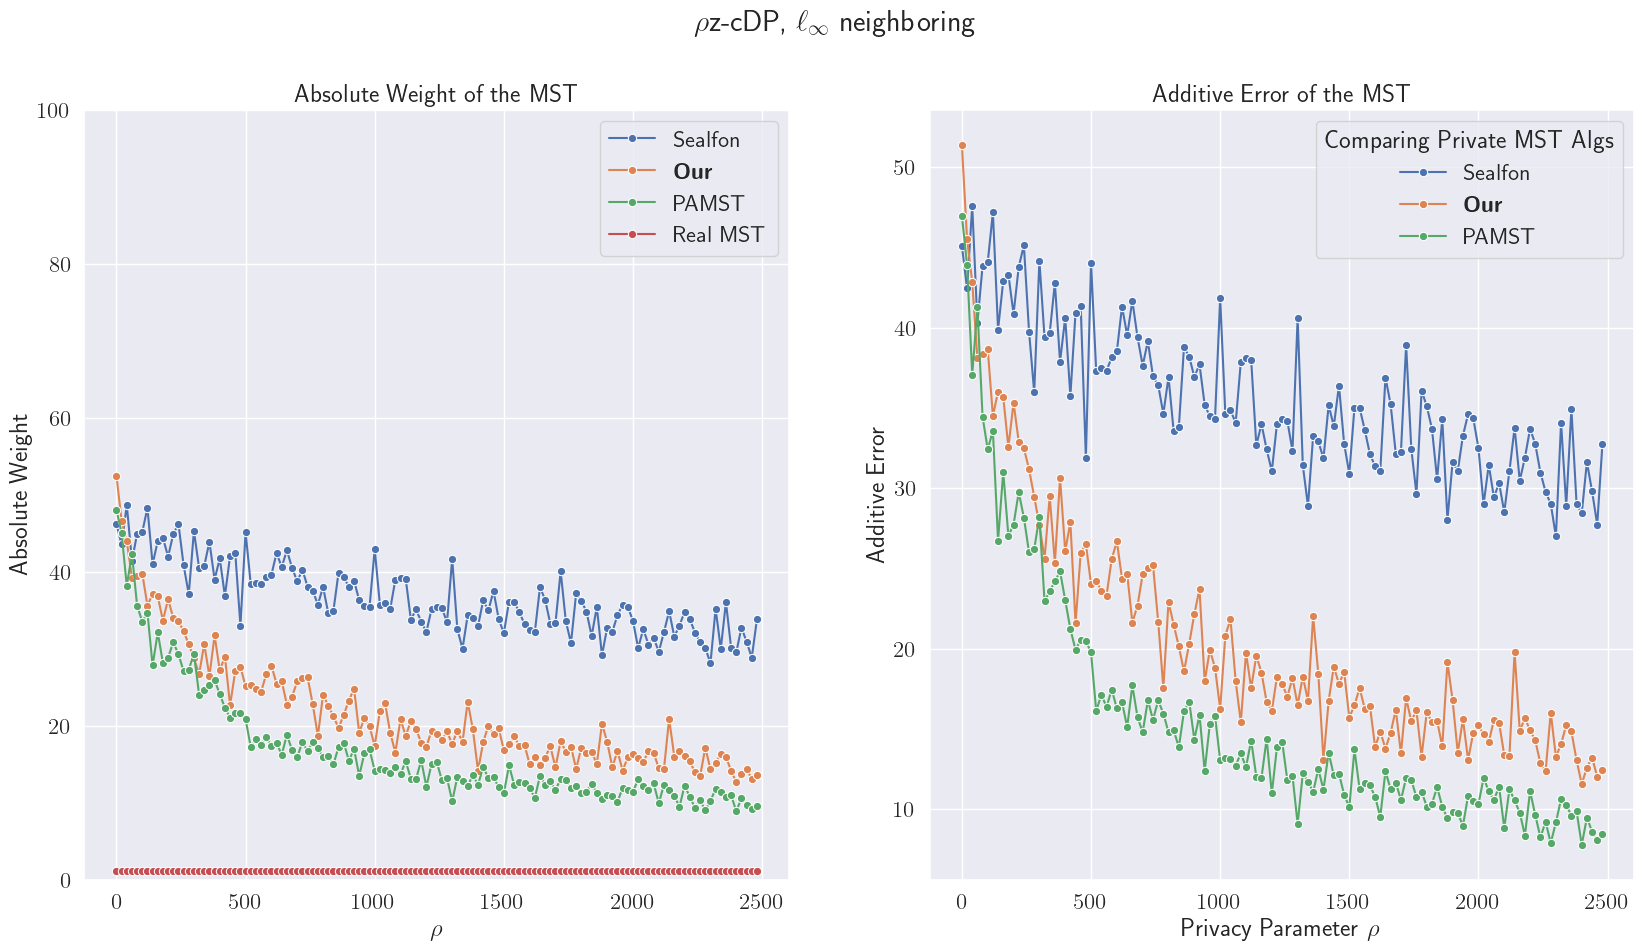

In [10]:
# Visualizing the results, Complete Graph

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

# Error of the MST
sns.lineplot(x= rho_values, y=sealfon_weights,marker='o', label="Sealfon", ax=axs[0])
#sns.lineplot(x=rho_values, y=upper, marker='o', label="upperbound", ax=axs[0])
sns.lineplot(x= rho_values, y=our_weights, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x= rho_values, y=pamst_weights, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x= rho_values, y=real_weights, marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")

# Error of the MST
sns.lineplot(x= rho_values, y=[sealfon - real for sealfon, real in zip(sealfon_weights, real_weights)] ,marker='o', label="Sealfon", ax=axs[1])
sns.lineplot(x= rho_values, y=[ours - real for ours, real in zip(our_weights, real_weights)] , marker='o', label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x= rho_values, y=[pamst - real for pamst, real in zip(pamst_weights, real_weights)] , marker='o', label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[0].set_ylim([0,100])

axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title = "Comparing Private MST Algs")
plt.show()


# Experiments on Hard Instances
We are using Sealfons instance to create an hard instance.

Real MST Weight: 0
[255.88914266403188, 73.5649455387632, 50.96985726099633, 48.898288115691514, 40.195514048130924, 34.16505878569597, 31.81082745181895, 29.132528646722648, 27.275005516515087, 25.888733459683117, 23.241404955174975, 24.005504874179696, 23.533145255571643, 20.797337860565584, 21.92562109770431, 19.855406679112214, 18.290899885832246, 17.861791252409123, 17.803689066680995, 18.946081296922554, 17.6292836437288, 17.30887690144163, 16.712589523084713, 17.22781066524305, 16.195769814656874, 16.151579466303254, 15.0103480695772, 15.72490444887349, 12.868806022550247, 15.174911470724657]


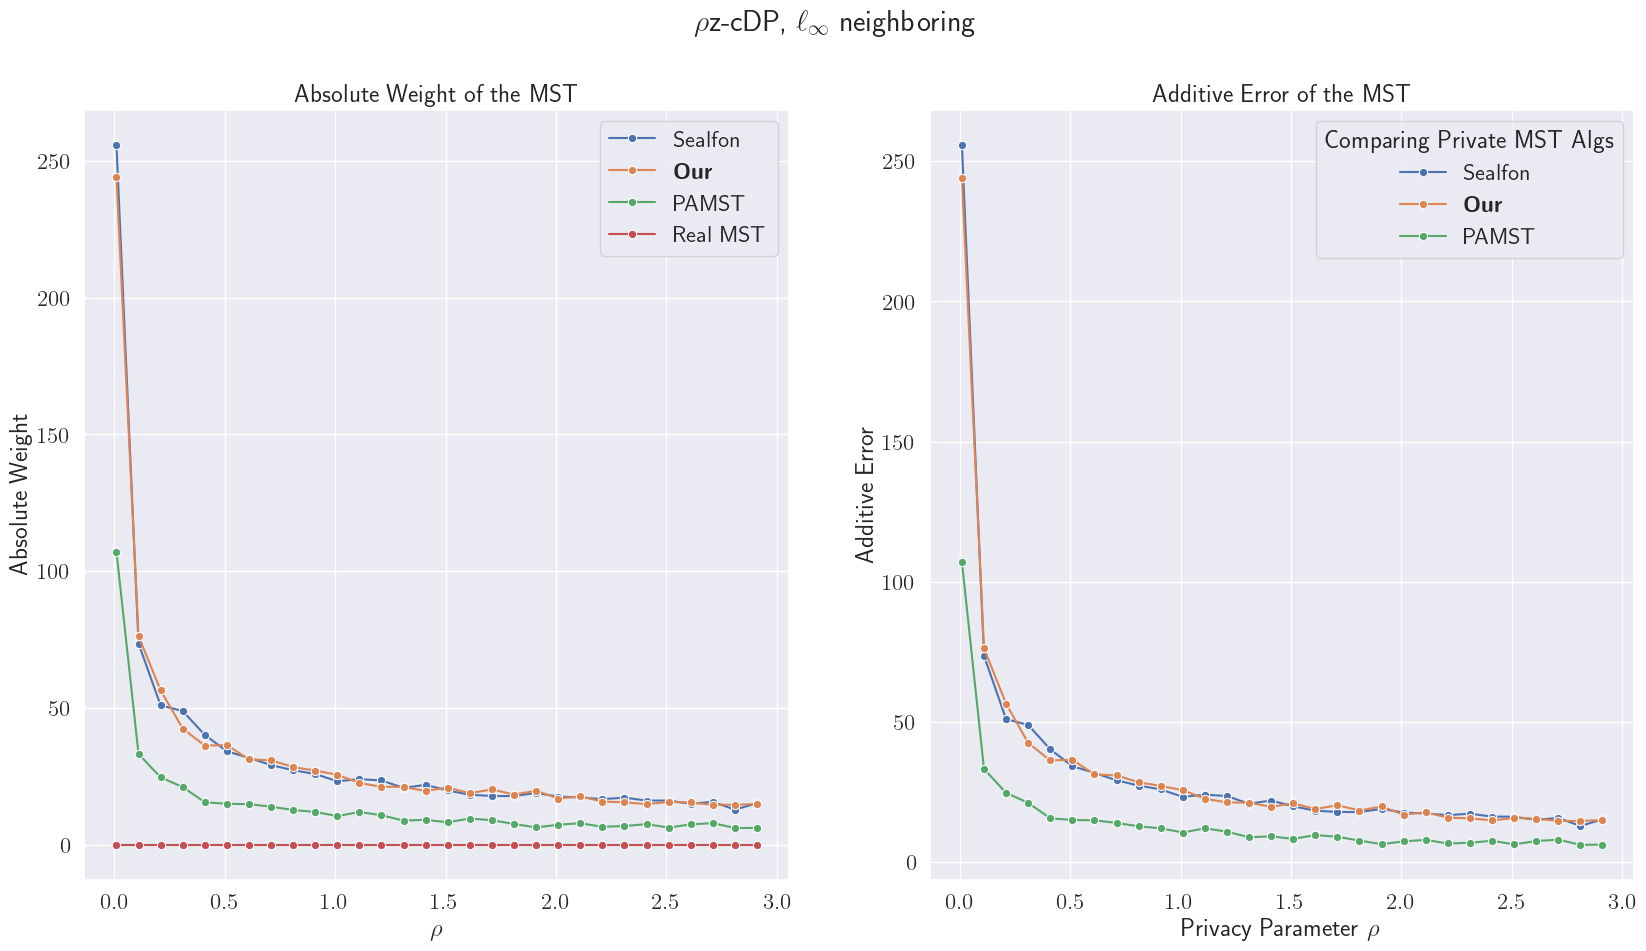

In [73]:
# Constructing an hard instance

# Privacy Parameters
rho_values = np.arange(0.01, 3, 0.1)
# rho_values = [0.001,0.02]
n = 250
sensitivity = 1

# Generate a enw graph
G = {}
for rho in rho_values:
    G[rho] = generate_hard_instance(n, 1/75* math.sqrt((n-1)/(2*rho)))
### Real Spanning Tree ###

# Simply make an array to make visualization easier

for rho in rho_values:
    real_weights = [compute_real_mst_weight(G[rho])] * len(rho_values)
print("Real MST Weight: " + str(real_weights[0]))

# Computing the upper bound
upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n)/(2*rho)]
    
### Pinot's PAMST Algorithm ###
pamst_weights = []
for rho in rho_values:
    noise_level = (2 * sensitivity * math.sqrt((n - 1) / (2 * rho)))  # Should be ok
    pamst_edges = pamst(G[rho], noise_level)  # Gives an iterator which should only be executed once!
    pamst_weights += [comp_mst_weight(pamst_edges)]

### Sealfon's Post Processing Technique ###

sealfon_weights = []
for rho in rho_values:
    noise_level = (n-1)/(2*rho)
    gaussNoise = lambda edge_weight: edge_weight + np.random.normal(0, noise_level)
    sealfon_weights += [compute_input_perturbation(G[rho].copy(), gaussNoise, alg='kruskal')]
    # print("Sealfon MST Weight: " + str(weight_sealfon))
print(sealfon_weights)

### Finally: Our Approach ###
our_weights = []
for rho in rho_values:
    noise_level = sensitivity * math.sqrt((2*rho)/(n-1))
    expNoise = lambda edge_weight: np.log(np.random.exponential(1)) + noise_level * edge_weight
    our_weights += [compute_input_perturbation(G[rho].copy(), expNoise)]
# Visualizing the results, Complete Graph

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

# Error of the MST
sns.lineplot(x=rho_values, y=sealfon_weights, marker='o', label="Sealfon", ax=axs[0])
#sns.lineplot(x=rho_values, y=upper, marker='o', label="upperbound", ax=axs[0])
sns.lineplot(x=rho_values, y=our_weights, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x=rho_values, y=pamst_weights, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x=rho_values, y=real_weights, marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")

# Error of the MST
sns.lineplot(x=rho_values, y=[sealfon - real for sealfon, real in zip(sealfon_weights, real_weights)], marker='o',
             label="Sealfon", ax=axs[1])
sns.lineplot(x=rho_values, y=[ours - real for ours, real in zip(our_weights, real_weights)], marker='o',
             label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x=rho_values, y=[pamst - real for pamst, real in zip(pamst_weights, real_weights)], marker='o',
             label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title="Comparing Private MST Algs")
plt.show()

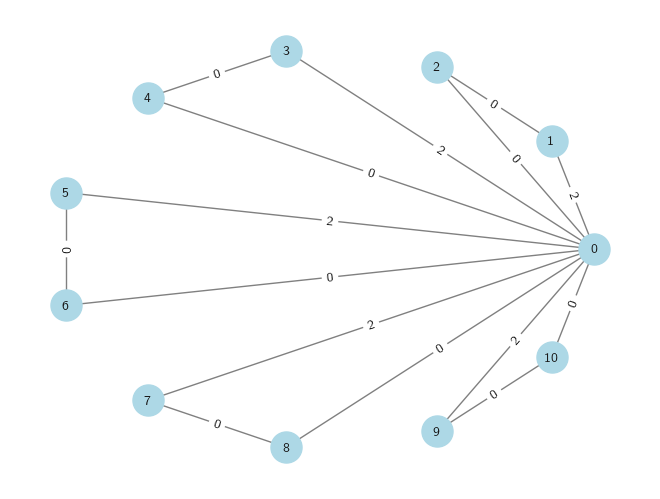

In [17]:
# Visualization of our hard instance
pos = nx.circular_layout(G)

G = generate_hard_instance(5, 1)
T = nx.minimum_spanning_tree(G, algorithm='prim')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.show()
